In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization
import requests

# Import PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from io import StringIO  # To read CSV from text response

from sklearn.preprocessing import MinMaxScaler # preprocessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error # evaluation metrics
from sklearn.linear_model import LinearRegression # linear regression model

from itertools import product # Import itertools for generating combinations
import heapq # Import heapq for getting top elements from a list
from joblib import Parallel, delayed

## **Data**

In [56]:
# Function to load CSV from GitHub URL using requests
def load_data_from_github(index_name):
    base_url = "https://raw.githubusercontent.com/AmaanRai1/DS-440---Group-2/main/"

    # Determine which file to use based on the index name
    if index_name == "DJI":
        file_url = f"{base_url}dji.csv"
    elif index_name == "GDAXI":
        file_url = f"{base_url}gdaxi.csv"
    elif index_name == "IBEX":
        file_url = f"{base_url}ibex.csv"
    else:
        raise ValueError(f"Invalid index name: {index_name}")

    # Use requests to get the content from the URL
    try:
        response = requests.get(file_url)
        response.raise_for_status()  # Raise HTTPError for bad responses (e.g., 404)

        # Convert the content to a StringIO object so that it can be read by pandas
        csv_content = StringIO(response.text)

        # Load the CSV content into a Pandas DataFrame
        df = pd.read_csv(csv_content)

        # Convert 'Date' column to datetime if it's not already in datetime format
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

        # Set the 'Date' column as the index
        df.set_index('Date', inplace=True)
        # Drop 'Volume' and 'Adj Close' columns if they exist
        df = df.drop(['Volume', 'Adj Close'], axis=1, errors='ignore')
        
        return df

    except requests.exceptions.HTTPError as http_err:
        raise ValueError(f"HTTP error occurred while fetching data from URL: {file_url} - {http_err}")
    except Exception as err:
        raise ValueError(f"Error occurred while fetching data from URL: {file_url} - {err}")

# Example usage for each index
def main(index_name):
    df = load_data_from_github(index_name)
    print(f"Data for {index_name}:")
    print(df.head())
    return df

# Testing the code (Optional)
if __name__ == "__main__":
    # Example to load DJI data
    df = main("DJI")

Data for DJI:
                   Open         High          Low        Close
Date                                                          
2011-01-03  11577.42969  11711.46973  11577.34961  11670.75000
2011-01-04  11670.90039  11698.21973  11635.74023  11691.17969
2011-01-05  11688.61035  11742.67969  11652.88965  11722.88965
2011-01-06  11716.92969  11736.74023  11667.45996  11697.30957
2011-01-07  11696.86035  11726.94043  11599.67969  11674.75977


In [ ]:
# Define the parameter ranges
short_range = range(2, 25)
mid_range = range(5, 41)
long_range = range(8, 81)

# test parameters
# short_range = range(2, 5)
# mid_range = range(5, 7)
# long_range = range(8, 12)

# Run the optimization
best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
best_tema_params = best_combinations[0]

# Print the results
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

NameError: name 'index_name' is not defined

In [41]:
# Define the split date
split_date = pd.to_datetime('2019-01-01')

# Split the data into train and test sets
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

# Step 2: Further split the train data into training and validation sets (80/20 split, or adjust as needed)
validation_split = int(0.8 * len(train_data))

train_data_final = train_data.iloc[:validation_split]  # 80% for training
validation_data = train_data.iloc[validation_split:]  # 20% for validation

# Initialize the scaler and fit it only on the training data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_final[['Open', 'Close', 'High', 'Low']])

# Use the fitted scaler to transform validation and test data
validation_data_scaled = scaler.transform(validation_data[['Open', 'Close', 'High', 'Low']])
test_data_scaled = scaler.transform(test_data[['Open', 'Close', 'High', 'Low']])

# Convert scaled data back to DataFrames for consistency in later processing steps
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=train_data_final.index)
validation_data_scaled = pd.DataFrame(validation_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=validation_data.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Open', 'Close', 'High', 'Low'], index=test_data.index)

In [42]:
def split_data_x(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index: index + time_window].reshape(-1))

    out = np.array(data)
    
    return out

In [43]:
def split_data_y(df, time_window, target_column='Close'):
    """
    Split a DataFrame into target sequences for each time window.
    This function extracts the 'y' (output) values for supervised learning.

    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.
        target_column (str): The name of the column to use as the target.

    Returns:
        np.ndarray: Numpy array of target sequences.
    """
    data_raw = np.array(df[target_column])  # get target column as numpy array
    data = []

    # create output sequences for each index up to the last time window
    for index in range(time_window, len(data_raw)):
        data.append(data_raw[index])

    return np.array(data).reshape(-1, 1)  # reshape for compatibility with PyTorch


In [44]:
# Helper function to split data into input and output sequences
def create_sequences(df, time_window, target_column='Close'):
    X, y = [], []
    data_raw = np.array(df)
    target = df[target_column]

    for i in range(len(data_raw) - time_window):
        X.append(data_raw[i: i + time_window].flatten())
        y.append(target.iloc[i + time_window])

    return np.array(X), np.array(y).reshape(-1, 1)

# Create train, validation, and test sequences
time_window = 6
x_train, y_train = create_sequences(train_data_final, time_window)
x_val, y_val = create_sequences(validation_data, time_window)
x_test, y_test = create_sequences(test_data, time_window)

## **Modeling and Evaluation Functions**

In [45]:
def calculate_profit_factor(strategy):
    """
    Calculate the profit factor of a trading strategy.

    Args:
        strategy (pd.Series): A pandas Series representing the strategy's trade outcomes.

    Returns:
        float: The profit factor of the strategy.
    """
    positive_trades = strategy.loc[strategy > 0].sum() # Calculate the sum of positive trades
    negative_trades = strategy.loc[strategy < 0].sum() # Calculate the sum of negative trades
    profit_factor = abs(positive_trades / negative_trades) # Calculate the profit factor
    return profit_factor

In [46]:
def calculate_metrics(df):
    # Calculate number of trades
    num_trades = df['Trades'].sum()
    
    # Calculate net profit of the trades
    net_profit = df['PriceStrategy'].sum()
    
    # Calculate profit factor
    profit_factor = calculate_profit_factor(df['Strategy'])
    
    # Calculate average net of each trade
    avg_net_trade = net_profit / num_trades
    
    # Calculate maximum drawdown (price)
    max_drawdown = (df['CPriceStrategy'] - df['CPriceStrategy'].cummax()).min()
    
    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Number of Trades': [num_trades],
        'Net Profit': [net_profit],
        'Profit Factor': [profit_factor],
        'Average Net per Trade': [avg_net_trade],
        'Maximum Drawdown': [max_drawdown],
    }, index=['Strategy'])
    
    return metrics_df

# Helper function for scaler predictions
def inverse_scale_predictions(scaler, y_pred):
    return scaler.inverse_transform(y_pred)

# Helper to make predictions for validation consistency
def make_prediction_df(predictions, validation_data, time_window, column_name='Predicted'):
    y_pred_df = pd.DataFrame(predictions, columns=[column_name], index=validation_data.index[-len(predictions):])
    y_pred_df = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=[column_name]), y_pred_df], ignore_index=True)
    return y_pred_df

In [47]:
def get_y_pred_lr(model, x_data, time_window):
    """
    Generates the y_pred_lr DataFrame using the provided model, input data, and time window.

    Args:
        model: The trained regression model used for predictions.
        x_data: The input data on which predictions are to be made.
        time_window: The time window used to add NaN rows at the beginning.

    Returns:
        pd.DataFrame: DataFrame with predictions and NaN padding.
    """
    # Generate predictions
    y_pred = model.predict(x_data)

    # Convert predictions to a DataFrame
    y_pred_lr = pd.DataFrame(y_pred, columns=['Predicted'])

    # Add NaN rows at the top for the time window
    y_pred_lr = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=['Predicted']), y_pred_lr],
                          ignore_index=True)
    
    return y_pred_lr


In [48]:
def get_y_pred_ann(model, x_test, test_data, scaler, time_window):
    """
    Generate predictions using the ANN model and prepare the y_pred_ann DataFrame.

    Args:
        model (torch.nn.Module): The trained ANN model.
        x_test (torch.Tensor): Test data for generating predictions.
        test_data (pd.DataFrame): Original test data for reference dates.
        scaler (MinMaxScaler): Scaler used for inverse transformation.
        time_window (int): Number of rows to add NaN values at the top of the DataFrame.

    Returns:
        pd.DataFrame: DataFrame with 'Predicted' column of ANN model predictions.
    """
    # Compute predictions on the test data
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)

    # Reshape y_pred to match the shape of the original data and apply inverse scaling
    y_pred = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    # Convert y_pred to a DataFrame and add NaN rows for initial indices
    y_pred_ann = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data.iloc[time_window:].index)
    y_pred_ann = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=['Predicted']), y_pred_ann], ignore_index=True)
    
    return y_pred_ann


In [49]:
def get_y_pred_lstm(model, x_test, test_data, scaler, time_window):
    """
    Generate predictions using the LSTM model and prepare the y_pred_lstm DataFrame.

    Args:
        model (torch.nn.Module): The trained LSTM model.
        x_test (torch.Tensor): Test data for generating predictions.
        test_data (pd.DataFrame): Original test data for reference dates.
        scaler (MinMaxScaler): Scaler used for inverse transformation.
        time_window (int): Number of rows to add NaN values at the top of the DataFrame.

    Returns:
        pd.DataFrame: DataFrame with 'Predicted' column of LSTM model predictions.
    """
    # Ensure x_test has the correct dimensions for LSTM
    if x_test.dim() == 2:
        x_test = x_test.unsqueeze(-1)

    # Compute predictions on the test data
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)

    # Reshape y_pred and apply inverse scaling
    y_pred = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

    # Convert y_pred to a DataFrame and add NaN rows for initial indices
    y_pred_lstm = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data.iloc[time_window:].index)
    y_pred_lstm = pd.concat([pd.DataFrame(np.nan, index=np.arange(time_window), columns=['Predicted']), y_pred_lstm], ignore_index=True)

    return y_pred_lstm

# **Strategies**

## **TEMA**

In [50]:
def ema(df, period):
    """
    Calculate the Exponential Moving Average (EMA) of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        period (int): The number of periods to consider for the EMA calculation.

    Returns:
        pd.DataFrame: The DataFrame with EMA values.

    """
    return df.ewm(span = period, min_periods = period).mean() 

In [51]:
def df_change(df, symbol):
    """
    Create a DataFrame with a single column representing the change in closing prices.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the change in closing prices.

    Returns:
        pd.DataFrame: A DataFrame with a single column representing the change in closing prices.

    """
    temp = pd.DataFrame(df['Close']) # Create a temporary DataFrame with 'Close' column
    temp = temp.rename({'Close': symbol}, axis=1) # Rename the 'Close' column to the specified symbol
    return temp

In [52]:
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    """
    Implement a trading strategy using TEMA (Triple Exponential Moving Average).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for short-term EMA calculation.
        mid_period (int): The period for mid-term EMA calculation.
        long_period (int): The period for long-term EMA calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame
    
    # Calculate the EMA values for short, mid, and long periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Determine the position based on EMA crossovers
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [53]:
def optimize_tema_parameters(df, symbol, short_range, mid_range, long_range):
    """
    Optimize TEMA (Triple Exponential Moving Average) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        mid_range (list): A list of mid-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []
    
    # Iterate over all combinations of short, mid, and long periods
    for short_period, mid_period, long_period in product(short_range, mid_range, long_range):
        if short_period < mid_period < long_period:
            
            # Calculate TEMA strategy performance for the combination of periods
            result = tema_strategy(df, symbol, short_period, mid_period, long_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [54]:
# Define the parameter ranges
short_range = range(2, 25)
mid_range = range(5, 41)
long_range = range(8, 81)

# test parameters
# short_range = range(2, 5)
# mid_range = range(5, 7)
# long_range = range(8, 12)

# Run the optimization
best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
best_tema_params = best_combinations[0]

# Print the results
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

NameError: name 'index_name' is not defined

In [ ]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination
    
    # Run the strategy with the current combination
    strategy_result = tema_strategy(test_data, index_name, short_period, mid_period, long_period,)
    
    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])
    
    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (15, 16, 17)
Profit Factor: 1.0924220195844727

Combination 2: (14, 18, 77)
Profit Factor: 0.9379749141028938

Combination 3: (11, 20, 21)
Profit Factor: 1.068844471399768

Combination 4: (15, 17, 18)
Profit Factor: 1.0850551252206113

Combination 5: (14, 17, 18)
Profit Factor: 1.0735750725169906



In [ ]:
print(best_tema_params[0], best_tema_params[1], best_tema_params[2])

15 16 17


In [ ]:
tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2])

,GDAXI,ShortEMA,MidEMA,LongEMA,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,NaN,NaN,0,-0.015577,-0.000000,-163.53027,-0.00000,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,NaN,NaN,0,0.033144,0.000000,351.03027,0.00000,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,NaN,NaN,NaN,0,-0.001848,-0.000000,-19.88086,-0.00000,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,NaN,NaN,NaN,0,0.005213,0.000000,56.17090,0.00000,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13204.179782,13200.696619,13197.097299,1,-0.000772,-0.000772,-10.20020,-10.20020,0.0,1.248745,1.065609,2631.76953,769.44045
2019-12-20,13318.90039,13218.519858,13214.602945,13210.630976,1,0.008062,0.008062,106.94043,106.94043,0.0,1.258853,1.074234,2738.70996,876.38088
2019-12-23,13300.98047,13228.827434,13224.765007,13220.669808,1,-0.001346,-0.001346,-17.91992,-17.91992,0.0,1.257159,1.072789,2720.79004,858.46096


In [ ]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


## **MACD**

In [ ]:
def macd_strategy(df, symbol, short_period, long_period, signal_period):
    """
    Implement a trading strategy using MACD (Moving Average Convergence Divergence).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for the short-term EMA calculation.
        long_period (int): The period for the long-term EMA calculation.
        signal_period (int): The period for the signal line calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame
    
    # Calculate the short-term and long-term EMAs and MACD line
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Generate trading signals based on MACD and signal line crossovers
    temp['Position'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs().replace(2,1)
    
    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [ ]:
def optimize_macd_parameters(df, symbol, short_range, long_range, signal_range):
    """
    Optimize MACD (Moving Average Convergence Divergence) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.
        signal_range (list): A list of signal line period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []
    
    # Iterate over all combinations of short, long, and signal periods
    for short_period, long_period, signal_period in product(short_range, long_range, signal_range):
        if short_period < long_period:
            
            # Calculate MACD strategy performance for the combination of periods
            result = macd_strategy(df, symbol, short_period, long_period, signal_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [ ]:
# Define the parameter ranges
short_range = range(2, 10)
long_range = range(5, 35)
signal_range = range(5, 20)

# test parameters
# short_range = range(2, 5)
# long_range = range(5, 7)
# signal_range = range(5, 10)

# Run the optimization
best_combinations, best_c_strategy = optimize_macd_parameters(train_data, index_name, short_range, long_range, signal_range)
best_macd_params = best_combinations[0]

# Print the best combinations and CStrategy values
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (4, 5, 5)
Combination 2: (3, 6, 5)
Combination 3: (3, 5, 6)
Combination 4: (2, 8, 5)
Combination 5: (2, 5, 8)
Best CStrategy: [2.955655504626256, 2.924800811375486, 2.924800811375486, 2.886587579080479, 2.886587579080479]


In [ ]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination
    
    # Run the strategy with the current combination
    strategy_result = macd_strategy(test_data, index_name, short_period, mid_period, long_period)
    
    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])
    
    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (4, 5, 5)
Profit Factor: 1.0167370508162197

Combination 2: (3, 6, 5)
Profit Factor: 0.973250364312905

Combination 3: (3, 5, 6)
Profit Factor: 0.973250364312905

Combination 4: (2, 8, 5)
Profit Factor: 0.9887143198127287

Combination 5: (2, 5, 8)
Profit Factor: 0.9887143198127287



In [ ]:
print(best_macd_params[0], best_macd_params[1], best_macd_params[2])

4 5 5


In [ ]:
macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2])

,GDAXI,ShortEMA,LongEMA,MACD Line,Signal Line,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,NaN,NaN,NaN,0,-0.015577,-0.000000,-163.53027,-0.00000,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,NaN,NaN,NaN,0,0.033144,0.000000,351.03027,0.00000,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,10681.867012,NaN,NaN,NaN,0,-0.001848,-0.000000,-19.88086,-0.00000,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,10734.830864,10722.388062,12.442803,NaN,0,0.005213,0.000000,56.17090,0.00000,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13241.731030,13241.349243,0.381787,6.787242,-1,-0.000772,0.000772,-10.20020,10.20020,0.0,1.248745,1.029545,2631.76953,436.14356
2019-12-20,13318.90039,13272.598774,13267.199625,5.399149,6.324544,-1,0.008062,-0.008062,106.94043,-106.94043,0.0,1.258853,1.021278,2738.70996,329.20313
2019-12-23,13300.98047,13283.951452,13278.459907,5.491546,6.046878,-1,-0.001346,0.001346,-17.91992,17.91992,0.0,1.257159,1.022654,2720.79004,347.12305


In [ ]:
# macd strategy metric outputs
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,47.0,222.89259,1.016737,4.742396,-1372.20216


## **RSI**

In [ ]:
def rsi_strategy(df, symbol, rsi_period):
    """
    Implement a trading strategy using RSI (Relative Strength Index).

    Args:
        df (pd.DataFrame): The input DataFrame containing historical price data.
        symbol (str): The name of the column representing the price data.
        rsi_period (int): The period for the RSI calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.
    """
    
    # Preprocess the data (e.g., calculate price changes)
    df = df_change(df, symbol)
    temp = df.copy()  # Create a copy of the DataFrame

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Generate trading signals based on RSI thresholds
    temp['Position'] = np.where(temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
                                np.where(temp['RSI'] > 70, -1, 0))  # Sell when RSI > 70 (Overbought)

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

def calculate_rsi(series, period):
    """Calculates the Relative Strength Index (RSI)."""
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [ ]:
def optimize_rsi_parameters(df, symbol, rsi_range):
    """
    Optimize RSI (Relative Strength Index) parameters by finding the best period based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame containing historical price data.
        symbol (str): The name of the column representing the price data.
        rsi_range (list): A list of RSI period values to consider.

    Returns:
        list: A list of best RSI periods.
        list: A list of corresponding CStrategy values.
    """
    top_combinations = []

    # Iterate over all possible RSI periods
    for rsi_period in rsi_range:
        # Calculate the RSI strategy performance for the given period
        result = rsi_strategy(df, symbol, rsi_period)
        c_strategy = result['CStrategy'].iloc[-1]  # Get the final CStrategy value

        # Use a heap to maintain the top 5 combinations based on CStrategy
        if len(top_combinations) < 5:
            heapq.heappush(top_combinations, (c_strategy, rsi_period))
        else:
            heapq.heappushpop(top_combinations, (c_strategy, rsi_period))

    # Get the top 5 RSI periods with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_periods = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]

    return best_periods, best_c_strategy

In [ ]:
# Define the parameter range for RSI periods
rsi_range = range(2, 30)  # Adjust this range based on your needs

# Test smaller ranges (for testing purposes)
# rsi_range = range(2, 5)

# Run the optimization
best_periods, best_c_strategy = optimize_rsi_parameters(train_data, index_name, rsi_range)

# Extract the best RSI period
best_rsi_period = best_periods[0]

# Print the best periods and their corresponding CStrategy values
print("Best RSI Periods:")
for i, period in enumerate(best_periods):
    print(f"Period {i+1}: {period} with CStrategy: {best_c_strategy[i]}")

print(f"\nBest RSI Period: {best_rsi_period}")


Best RSI Periods:
Period 1: 5 with CStrategy: 1.4498055919088544
Period 2: 13 with CStrategy: 1.4482066638126252
Period 3: 8 with CStrategy: 1.4201882620512079
Period 4: 10 with CStrategy: 1.3555477093894663
Period 5: 16 with CStrategy: 1.3271021075036666

Best RSI Period: 5


In [ ]:
def calculate_profit_factor(strategy_returns):
    """
    Calculate the profit factor for a given strategy.

    Args:
        strategy_returns (pd.Series): A series of strategy returns.

    Returns:
        float: The profit factor (ratio of gross profit to gross loss).
    """
    # Separate profits and losses
    gross_profit = strategy_returns[strategy_returns > 0].sum()
    gross_loss = abs(strategy_returns[strategy_returns < 0].sum())

    # Avoid division by zero by checking for zero gross loss
    if gross_loss == 0:
        return float('inf')  # Return infinity if there are no losses

    return gross_profit / gross_loss

In [ ]:
print(f"Printing five of the best RSI period combinations:\n")

for i, period in enumerate(best_periods):
    # Run the RSI strategy with the current period
    strategy_result = rsi_strategy(test_data, index_name, period)

    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])

    # Print the result
    print(f"Period {i+1}: {period}")
    print("Profit Factor:", pf_factor)
    print()


Printing five of the best RSI period combinations:

Period 1: 5
Profit Factor: 1.2728715203029541

Period 2: 13
Profit Factor: 0.901634720102489

Period 3: 8
Profit Factor: 0.8838836935914389

Period 4: 10
Profit Factor: 1.0638955732607642

Period 5: 16
Profit Factor: 1.0891328154369797



In [ ]:
rsi_strategy(test_data, index_name, best_rsi_period)

,GDAXI,RSI,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,0,-0.015577,-0.0,-163.53027,-0.0,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,0,0.033144,0.0,351.03027,0.0,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,NaN,0,-0.001848,-0.0,-19.88086,-0.0,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,68.945596,0,0.005213,0.0,56.17090,0.0,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,48.732098,0,-0.000772,-0.0,-10.20020,-0.0,0.0,1.248745,1.099444,2631.76953,1110.94044
2019-12-20,13318.90039,54.230854,0,0.008062,0.0,106.94043,0.0,0.0,1.258853,1.099444,2738.70996,1110.94044
2019-12-23,13300.98047,33.360446,0,-0.001346,-0.0,-17.91992,-0.0,0.0,1.257159,1.099444,2720.79004,1110.94044


In [ ]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,85.0,1110.94044,1.272872,13.069888,-959.13965


# **Prediction**

## **Linear Regression**

In [ ]:
# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [ ]:
# Evaluate the model on validation data
y_val_pred = regression_model.predict(x_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_metrics = {
    'Validation MAE': val_mae,
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Validation sMAPE': np.mean(np.abs((y_val - y_val_pred) / (np.abs(y_val) + np.abs(y_val_pred))) * 200),
    'Validation MAPE': np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
}

In [ ]:
# Evaluate the model on test data
y_test_pred = regression_model.predict(x_test)
test_metrics = {
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Test sMAPE': np.mean(np.abs((y_test - y_test_pred) / (np.abs(y_test) + np.abs(y_test_pred))) * 200),
    'Test MAPE': np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

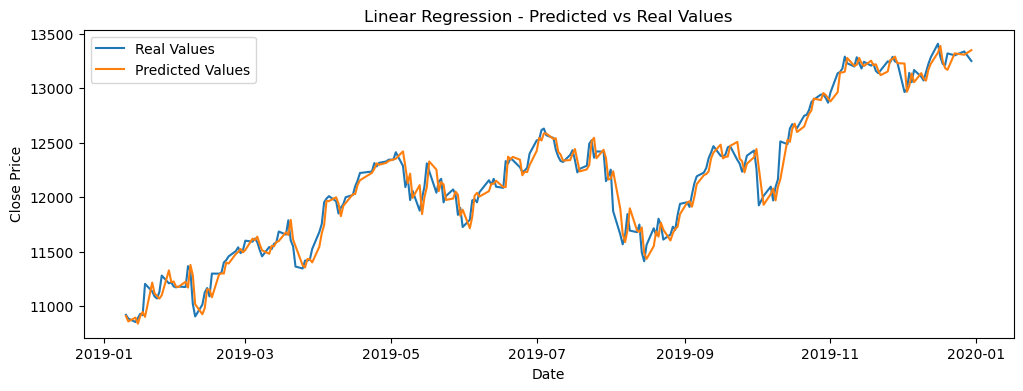

In [ ]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_test_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Predicted vs Real Values')
plt.legend()
plt.show()

In [ ]:
# saving the prediction price for further use
y_pred_lr = get_y_pred_lr(regression_model, x_test, time_window)


## **ANN**

In [ ]:
# Define the updated ANN model with Dropout
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)  # Increase to 256
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.4)  # Increase dropout to 40%

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)  # Additional dropout layer
        x = torch.relu(self.layer3(x))
        x = self.output(x)
        return x


In [ ]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_val = split_data_x(validation_data_scaled, time_window)
y_val = split_data_y(validation_data, time_window)                      
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [ ]:
# transforming numpy to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
# Set the hyperparameters
hidden_size = 16
lr = 0.00001
num_iterations = 5000

In [ ]:
# Define the model
input_size = x_train.shape[1]
output_size = 1
ann_model = ANNModel(input_size=x_train.shape[1])  # Define input size based on x_train

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.0001)

In [ ]:
# Implement early stopping
early_stop_threshold = 10  # Stop if no improvement after 10 iterations
best_val_loss = float('inf')
no_improvement_count = 0

In [ ]:
num_epochs = 5000
for epoch in range(num_epochs):
    ann_model.train()
    optimizer.zero_grad()
    outputs = ann_model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation step
    ann_model.eval()
    with torch.no_grad():
        val_outputs = ann_model(x_val)
        val_loss = criterion(val_outputs, y_val)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

Early stopping at epoch 201


In [ ]:
# Compute predictions on the test data
y_pred = ann_model(x_test)

# Reshape the y_pred array to match the shape of the original data
y_pred = y_pred.detach().numpy().reshape(-1, 1)

# Scale the test_data['Close'] using the same scaler used for training data
temp = scaler.fit_transform(test_data[['Close']])

# Inverse transform the scaled y_pred values to get the actual predicted values
y_pred = scaler.inverse_transform(y_pred)

# Convert y_test tensor to a NumPy array
y_test = y_test.detach().numpy()

In [ ]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 802.2879
Root Mean Squared Error (RMSE): 924.1879
Symmetric Mean Absolute Percentage Error (sMAPE): 3.2610745
Mean Absolute Percentage Error (MAPE): 6.824423372745514


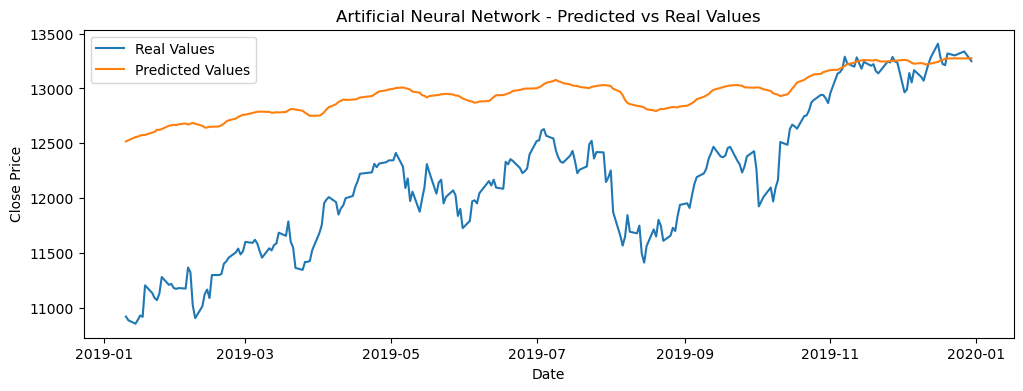

In [ ]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Artificial Neural Network - Predicted vs Real Values')
plt.legend()
plt.show()

In [ ]:
y_pred_ann = get_y_pred_ann(ann_model, x_test, test_data, scaler, time_window)

# **LSTM**

In [ ]:
# Define the updated LSTM model with increased hidden size and layers
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Get the last timestep output
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
# Instantiate model, criterion, and optimizer
lstm_model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001, weight_decay=1e-4)

# Set up a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# Early stopping parameters
early_stop_threshold = 20
best_val_loss = float('inf')
no_improvement_count = 0

/Users/amaanrai/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# Ensure x_train, x_val, and x_test have three dimensions
if x_train.dim() == 2:
    x_train = x_train.unsqueeze(-1)
if x_val.dim() == 2:
    x_val = x_val.unsqueeze(-1)
if x_test.dim() == 2:
    x_test = x_test.unsqueeze(-1)

In [ ]:
# Set up DataLoader for batch processing
batch_size = 32
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Training loop with early stopping
num_epochs = 300
for epoch in range(num_epochs):
    lstm_model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    # Validation step
    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(x_val)
        val_loss = criterion(val_outputs, y_val)

    # Learning rate adjustment based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

Epoch [10/300], Training Loss: 0.0013477833708748221, Validation Loss: 154845216.0
Epoch [20/300], Training Loss: 0.0004015559097751975, Validation Loss: 154847072.0
Early stopping at epoch 26


In [ ]:
y_pred_lstm = get_y_pred_lstm(lstm_model, x_test, test_data, scaler, time_window)

# **Hybrid Strategies**

## **Strategy 1**

![image.png](attachment:image.png)

### **hTEMA**

In [ ]:
def htema_strategy(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [ ]:
htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm)


,GDAXI,ShortEMA,MidEMA,LongEMA,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,NaN,NaN,NaN,0,0,0,-0.015577,-0.000000,-163.53027,-0.00000,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,NaN,NaN,NaN,0,0,0,0.033144,0.000000,351.03027,0.00000,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,NaN,NaN,NaN,NaN,0,0,0,-0.001848,-0.000000,-19.88086,-0.00000,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,NaN,NaN,NaN,NaN,0,0,0,0.005213,0.000000,56.17090,0.00000,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13204.179782,13200.696619,13197.097299,13477.508789,-1,1,1,-0.000772,-0.000772,-10.20020,-10.20020,0.0,1.248745,1.065609,2631.76953,769.44045
2019-12-20,13318.90039,13218.519858,13214.602945,13210.630976,13474.241211,-1,1,1,0.008062,0.008062,106.94043,106.94043,0.0,1.258853,1.074234,2738.70996,876.38088
2019-12-23,13300.98047,13228.827434,13224.765007,13220.669808,13471.074219,-1,1,1,-0.001346,-0.001346,-17.91992,-17.91992,0.0,1.257159,1.072789,2720.79004,858.46096


#### **Comparing TEMA and hTEMA**

In [ ]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


In [ ]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


### **hMACD**

In [ ]:
def hmacd_strategy(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [ ]:
hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm)

,GDAXI,ShortEMA,LongEMA,MACD Line,Signal Line,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,NaN,NaN,NaN,NaN,0,0,0,-0.015577,-0.000000,-163.53027,-0.00000,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,NaN,NaN,NaN,NaN,0,0,0,0.033144,0.000000,351.03027,0.00000,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,10681.867012,NaN,NaN,NaN,NaN,0,0,0,-0.001848,-0.000000,-19.88086,-0.00000,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,10734.830864,10722.388062,12.442803,NaN,NaN,0,0,0,0.005213,0.000000,56.17090,0.00000,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,13241.731030,13241.349243,0.381787,6.787242,13477.508789,-1,-1,-1,-0.000772,0.000772,-10.20020,10.20020,0.0,1.248745,1.029545,2631.76953,436.14356
2019-12-20,13318.90039,13272.598774,13267.199625,5.399149,6.324544,13474.241211,-1,-1,-1,0.008062,-0.008062,106.94043,-106.94043,0.0,1.258853,1.021278,2738.70996,329.20313
2019-12-23,13300.98047,13283.951452,13278.459907,5.491546,6.046878,13471.074219,-1,-1,-1,-0.001346,0.001346,-17.91992,17.91992,0.0,1.257159,1.022654,2720.79004,347.12305


#### **Comparing MACD and hMACD**

In [ ]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,47.0,222.89259,1.016737,4.742396,-1372.20216


In [ ]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,47.0,222.89259,1.016737,4.742396,-1372.20216


## **hRSI**

In [ ]:
def hrsi_strategy(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the Relative Strength Index (RSI) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    # Align the dataframe with the predictions
    df = df_change(df, symbol)  # Preprocess data (e.g., handle NaNs or changes)
    adjusted_split = len(df) - len(y_pred)  # Find the index to align with predictions
    df = df.iloc[adjusted_split:]  # Trim the DataFrame
    temp = df.copy()  # Make a copy of the aligned dataframe

    # Calculate the RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Determine strategy position based on RSI
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy when RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell when RSI > 70 (Overbought)
    )

    # Generate final trading signals by combining strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
        np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0)
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate the number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

In [ ]:
hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm)

,GDAXI,RSI,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,10580.19043,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.00000,NaN
2019-01-03,10416.66016,NaN,NaN,0,0,0,-0.015577,-0.0,-163.53027,-0.0,0.0,0.984544,1.000000,-163.53027,0.00000
2019-01-04,10767.69043,NaN,NaN,0,0,0,0.033144,0.0,351.03027,0.0,0.0,1.017722,1.000000,187.50000,0.00000
2019-01-07,10747.80957,NaN,NaN,0,0,0,-0.001848,-0.0,-19.88086,-0.0,0.0,1.015843,1.000000,167.61914,0.00000
2019-01-08,10803.98047,68.945596,NaN,0,0,0,0.005213,0.0,56.17090,0.0,0.0,1.021152,1.000000,223.79004,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,13211.95996,48.732098,13477.508789,-1,0,0,-0.000772,-0.0,-10.20020,-0.0,0.0,1.248745,1.102297,2631.76953,1139.20997
2019-12-20,13318.90039,54.230854,13474.241211,-1,0,0,0.008062,0.0,106.94043,0.0,0.0,1.258853,1.102297,2738.70996,1139.20997
2019-12-23,13300.98047,33.360446,13471.074219,-1,0,0,-0.001346,-0.0,-17.91992,-0.0,0.0,1.257159,1.102297,2720.79004,1139.20997


#### Comparing RSI and hRSI

In [ ]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,85.0,1110.94044,1.272872,13.069888,-959.13965


In [ ]:
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,85.0,1139.20997,1.282438,13.40247,-959.13965


## **Strategy 2**

![image.png](attachment:image.png)

### **hTEMA**

In [ ]:
def htema_strategy_2(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

#### **Comparing TEMA, hTEMA1, and hTEMA2**

In [ ]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


In [ ]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,11.0,806.49026,1.092422,73.317296,-1335.4912


In [ ]:
calculate_metrics(htema_strategy_2(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,2.0,-2327.41993,0.782086,-1163.709965,-2551.75


In [ ]:
# Reshape x_val to remove the third dimension
x_val = x_val.squeeze(dim=2)  # This changes x_val to shape [403, 24]

# Ensure the index length matches the shape of y_pred_val
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val), 
    columns=['Predicted'], 
    index=validation_data.index[-len(x_val):]  # Adjusting to the correct length
)

In [ ]:
# Adjust y_pred_val to match the length of validation_data
if len(y_pred_val) > len(validation_data):
    print("Trimming y_pred_val to match validation_data length")
    y_pred_val = y_pred_val.iloc[-len(validation_data):]

# Now `y_pred_val` should match `validation_data` in length
print("y_pred_val length after adjustment:", len(y_pred_val))
print("validation_data length:", len(validation_data))

# Run the strategy with the adjusted y_pred_val
print("Validation Set Metrics:")
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_val))


y_pred_val length after adjustment: 399
validation_data length: 405
Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2056.09961,0.874903,-2056.09961,-3178.08984


In [ ]:
# Ensure the index length matches the shape of y_pred_val
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val), 
    columns=['Predicted'], 
    index=validation_data.index[-len(x_val):]  # Adjusting to the correct length
)

print("Validation Set Metrics:")
calculate_metrics(htema_strategy(validation_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_val))

Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2056.09961,0.874903,-2056.09961,-3178.08984


### **hMACD**

In [ ]:
def hmacd_strategy_2(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to trim
    df = df.iloc[adjusted_split:]  # Trim the dataframe to the last 'len(y_pred)' rows
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

#### **Comparing MACD, hMACD1, and hMACD2**

In [ ]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,47.0,222.89259,1.016737,4.742396,-1372.20216


In [ ]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,49.0,808.61331,1.075546,16.502312,-1372.20216


In [ ]:
calculate_metrics(hmacd_strategy_2(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_ann))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,7.0,-1846.59961,0.819397,-263.799944,-2330.25977


In [ ]:
# Ensure the index length matches the shape of y_pred_val
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val), 
    columns=['Predicted'], 
    index=validation_data.index[-len(x_val):]  # Adjusting to the correct length
)

print("Validation Set Metrics:")
calculate_metrics(hmacd_strategy(validation_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_val))

Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2056.09961,0.874903,-2056.09961,-3178.08984


### **hRSI**

In [ ]:
def hrsi_strategy_2(df, symbol, rsi_period, y_pred):
    """
    Implements a trading strategy based on the RSI (Relative Strength Index) combined with machine learning predictions.

    Args:
        df (pd.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe representing the price data.
        rsi_period (int): Look-back period for RSI calculation.
        y_pred (pd.DataFrame): Dataframe containing predicted values.

    Returns:
        pd.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    # Preprocess data and align with predictions
    df = df_change(df, symbol)
    adjusted_split = len(df) - len(y_pred)  # Find the starting index to align with predictions
    df = df.iloc[adjusted_split:]  # Trim the DataFrame to align with y_pred
    temp = df.copy()  # Create a copy of the trimmed DataFrame

    # Calculate RSI
    temp['RSI'] = calculate_rsi(temp[symbol], rsi_period)

    # Add predicted prices and generate prediction positions
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where(
        temp['PredictionPrice'] < temp[symbol].shift(-1), 1,  # Predict price increase -> Buy
        np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0)  # Predict price drop -> Sell
    )

    # Generate RSI-based strategy positions
    temp['StrategyPosition'] = np.where(
        temp['RSI'] < 30, 1,  # Buy if RSI < 30 (Oversold)
        np.where(temp['RSI'] > 70, -1, 0)  # Sell if RSI > 70 (Overbought)
    )

    # Generate final trading signals using strategy and prediction positions
    temp['Position'] = np.where(
        (temp['StrategyPosition'] == 1) & (temp['PredictionPosition'] == 1), 1,  # Buy if both signals agree
        np.where((temp['StrategyPosition'] == -1) | (temp['PredictionPosition'] == -1), -1, 0)  # Sell if either signals sell
    )

    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']

    # Calculate profit based on price changes
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp['Position'].shift(1) * temp['PriceChange']

    # Calculate number of trades and ensure single trades
    temp['Trades'] = temp['Position'].diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)

    # Calculate cumulative metrics
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp['CStrategy'] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()

    return temp

#### Comparing RSI, hRSI1, and hRSI2

In [ ]:
calculate_metrics(rsi_strategy(test_data, index_name, best_rsi_period))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,85.0,1110.94044,1.272872,13.069888,-959.13965


In [ ]:
calculate_metrics(hrsi_strategy(test_data, index_name, best_rsi_period, y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,93.0,10606.84081,6.85356,114.052052,-304.48047


In [ ]:
calculate_metrics(hrsi_strategy_2(test_data, index_name, best_rsi_period, y_pred_lstm))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,2.0,-2355.68946,0.779806,-1177.84473,-2551.75


In [ ]:
# Ensure the index length matches the shape of y_pred_val
y_pred_val = pd.DataFrame(
    regression_model.predict(x_val), 
    columns=['Predicted'], 
    index=validation_data.index[-len(x_val):]  # Adjusting to the correct length
)

print("Validation Set Metrics:")
calculate_metrics(hrsi_strategy(validation_data, index_name, best_rsi_period, y_pred_val))


Validation Set Metrics:


,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,1.0,-2056.09961,0.874903,-2056.09961,-3178.08984
